[medium](https://medium.com/@dikaelsaputra/memprediksi-keberhasilan-tmdb-konten-tv-7b6826951b50)

[github](https://github.com/figuran04/big-data/tree/main/proyek-akhir)

### **Membaca Dataset dan Menampilkan Statistik Awal**

In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer

# Load Data
df = pd.read_csv("/content/drive/MyDrive/TMDB_tv_dataset_v3.csv")
print(df.head())
print(df.info())

      id              name  number_of_seasons  number_of_episodes  \
0   1399   Game of Thrones                  8                  73   
1  71446       Money Heist                  3                  41   
2  66732   Stranger Things                  4                  34   
3   1402  The Walking Dead                 11                 177   
4  63174           Lucifer                  6                  93   

  original_language  vote_count  vote_average  \
0                en       21857         8.442   
1                es       17836         8.257   
2                en       16161         8.624   
3                en       15432         8.121   
4                en       13870         8.486   

                                            overview  adult  \
0  Seven noble families fight for control of the ...  False   
1  To carry out the biggest heist in history, a m...  False   
2  When a young boy vanishes, a small town uncove...  False   
3  Sheriff's deputy Rick Grimes awaken

### **Identifying missing data.**

In [ ]:
# Check Missing Data
missing_data = df.isnull().sum()
print("Nilai yang hilang per kolom:\n", missing_data)

Nilai yang hilang per kolom:
 id                           0
name                         5
number_of_seasons            0
number_of_episodes           0
original_language            0
vote_count                   0
vote_average                 0
overview                 75306
adult                        0
backdrop_path            90859
first_air_date           31736
last_air_date            29904
homepage                117641
in_production                0
original_name                5
popularity                   0
poster_path              59902
type                         0
status                       0
tagline                 163309
genres                   68926
created_by              132143
languages                58589
networks                 71050
origin_country           31030
spoken_languages         59359
production_companies    109297
production_countries     91128
episode_run_time             0
dtype: int64


### **Data Filtering, Dropping Columns and Deduplication.**

In [ ]:
# Drop Columns and Rows Based on Thresholds
threshold = 0.5 * len(df)
df.dropna(thresh=threshold, axis=1, inplace=True)
df.dropna(subset=['name'], inplace=True)
df.drop_duplicates(subset=['id'], inplace=True)
df = df[df['popularity'] > 0]

# Re-check Missing Data
missing_data = df.isnull().sum()
print("Nilai yang hilang per kolom:\n", missing_data)

Nilai yang hilang per kolom:
 id                        0
name                      0
number_of_seasons         0
number_of_episodes        0
original_language         0
vote_count                0
vote_average              0
overview              72398
adult                     0
first_air_date        30788
last_air_date         28852
in_production             0
original_name             0
popularity                0
poster_path           58240
type                      0
status                    0
genres                66297
languages             56091
networks              66509
origin_country        30817
spoken_languages      56830
episode_run_time          0
dtype: int64


### **Filling Missing Values, Dropping Rows and Standardizing Genres Data**

In [ ]:
# Fill Missing Data and Standardize
df['genres'] = df['genres'].fillna('Unknown').str.lower()

country_map = {
    'US': 'English', 'ES': 'Español', 'JP': '日本語', 'KR': '한국어',
    'FR': 'Français', 'DE': 'Deutsch', 'IT': 'Italiano', 'IN': 'हिन्दी',
    'GB': 'English', 'CA': 'English', 'AU': 'English', 'BR': 'Português',
    'MX': 'Español', 'RU': 'Русский'
}

def standardize_and_fill_na(col, ref_col):
    col = col.astype(str).str.upper().fillna('UNKNOWN')
    ref_col = ref_col.astype(str).str.upper().fillna('UNKNOWN')
    return col.map(country_map).where(ref_col == 'US', col).where(ref_col == 'ES', col)

df['origin_country'] = standardize_and_fill_na(df['origin_country'], df['original_language'])
df['original_language'] = standardize_and_fill_na(df['original_language'], df['origin_country'])
df['languages'] = standardize_and_fill_na(df['languages'], df['origin_country'])

def fill_spoken_languages(row):
    if row['origin_country'] in ['US', 'EN', 'CA', 'AU', 'GB']:
        return 'English'
    elif row['origin_country'] in ['ES', 'MX']:
        return 'Español'
    elif row['origin_country'] == 'JP':
        return '日本語'
    elif row['origin_country'] == 'KR':
        return '한국어'
    elif row['origin_country'] == 'FR':
        return 'Français'
    elif row['origin_country'] == 'DE':
        return 'Deutsch'
    elif row['origin_country'] == 'IT':
        return 'Italiano'
    elif row['origin_country'] == 'IN':
        return 'हिन्दी'
    elif row['origin_country'] == 'BR':
        return 'Português'
    elif row['origin_country'] == 'RU':
        return 'Русский'
    else:
        return 'Unknown'

df['spoken_languages'] = df.apply(fill_spoken_languages, axis=1)


In [ ]:
# Drop Columns and Rows Based on Updated Threshold
threshold = 0.7 * len(df)
df.dropna(thresh=threshold, axis=1, inplace=True)
df.dropna(subset=['first_air_date', 'last_air_date'], inplace=True)

# Re-check Missing Data
print(len(df))
missing_data = df.isnull().sum()
print("Nilai yang hilang per kolom:\n", missing_data)

130858
Nilai yang hilang per kolom:
 id                    0
name                  0
number_of_seasons     0
number_of_episodes    0
original_language     0
vote_count            0
vote_average          0
adult                 0
first_air_date        0
last_air_date         0
in_production         0
original_name         0
popularity            0
type                  0
status                0
genres                0
languages             0
origin_country        0
spoken_languages      0
episode_run_time      0
dtype: int64


### **Outlier Detection and Handling**

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Outlier Detection and Handling
numerical_columns = [
    "number_of_seasons", "number_of_episodes",
    "vote_count", "vote_average", "popularity", "episode_run_time"
]

Q1 = df[numerical_columns].quantile(0.25)
Q3 = df[numerical_columns].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = ((df[numerical_columns] < lower_bound) | (df[numerical_columns] > upper_bound))

outliers_summary = outliers.sum()
print("Jumlah outlier per kolom:")
print(outliers_summary)

cols_to_impute = ["number_of_seasons", "number_of_episodes"]
for col in cols_to_impute:
    median = df[col].median()
    df[col] = df[col].mask(outliers[col], median)
print(df[["number_of_seasons", "number_of_episodes"]])

Jumlah outlier per kolom:
number_of_seasons     30396
number_of_episodes    13092
vote_count            16332
vote_average              0
popularity            18229
episode_run_time       2223
dtype: int64
        number_of_seasons  number_of_episodes
0                       1                  10
1                       1                  41
2                       1                  34
3                       1                  10
4                       1                  10
...                   ...                 ...
168593                  1                   1
168630                  1                  32
168633                  1                   8
168636                  1                   1
168637                  1                   1

[130858 rows x 2 columns]


In [ ]:
# Log Transformation
df["popularity"] = np.log1p(df["popularity"])
df["vote_count"] = np.log1p(df["vote_count"])

print(df[["popularity", "vote_count"]])

        popularity  vote_count
0         6.989259    9.992322
1         4.578354    9.789030
2         5.229562    9.690418
3         6.195927    9.644263
4         6.034687    9.537556
...            ...         ...
168593    0.470004    0.000000
168630    1.549688    0.000000
168633    1.393270    0.000000
168636    1.062985    0.000000
168637    0.470004    0.000000

[130858 rows x 2 columns]


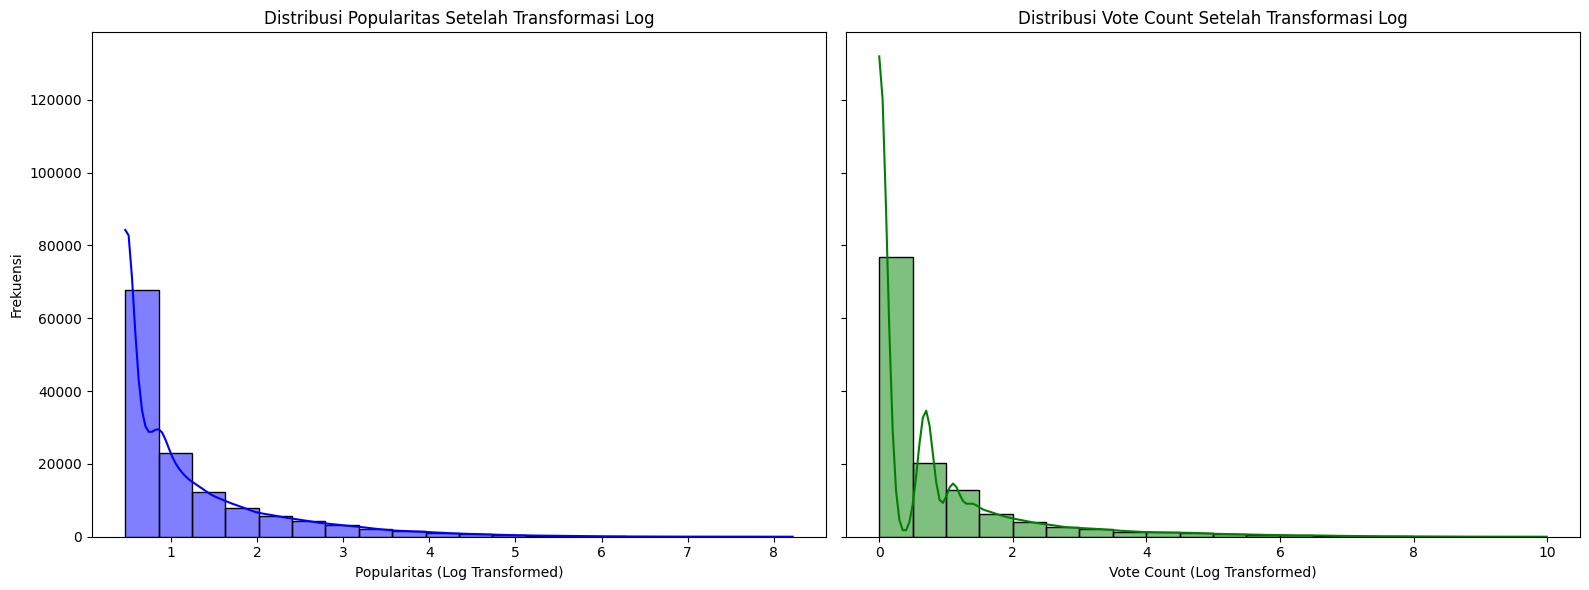

In [ ]:
# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Histogram for "popularity"
sns.histplot(df["popularity"], kde=True, color="blue", bins=20, ax=axes[0])
axes[0].set_title("Distribusi Popularitas Setelah Transformasi Log")
axes[0].set_xlabel("Popularitas (Log Transformed)")
axes[0].set_ylabel("Frekuensi")

# Histogram for "vote_count"
sns.histplot(df["vote_count"], kde=True, color="green", bins=20, ax=axes[1])
axes[1].set_title("Distribusi Vote Count Setelah Transformasi Log")
axes[1].set_xlabel("Vote Count (Log Transformed)")
axes[1].set_ylabel("Frekuensi")

plt.tight_layout()
plt.show()

        episode_run_time
1                     70
3                     42
4                     45
5                     45
8                     43
...                  ...
168513                23
168520                60
168523                10
168558                60
168577                60

[71723 rows x 1 columns]


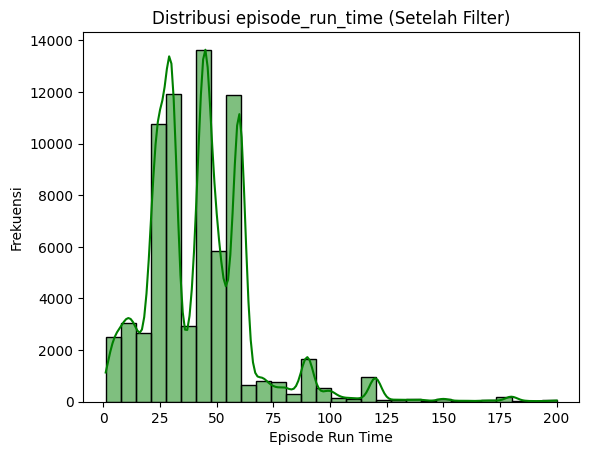

In [ ]:
# Filter "episode_run_time"
df = df[(df["episode_run_time"] >= 1) & (df["episode_run_time"] <= 200)]
print(df[["episode_run_time"]])
sns.histplot(df["episode_run_time"], bins=30, kde=True, color="green")
plt.title("Distribusi episode_run_time (Setelah Filter)")
plt.xlabel("Episode Run Time")
plt.ylabel("Frekuensi")
plt.show()

In [ ]:
# Statistics
print(df.describe())

                  id  number_of_seasons  number_of_episodes    vote_count  \
count   71723.000000            71723.0        71723.000000  71723.000000   
mean    87652.868745                1.0           14.255720      1.076015   
std     63203.546338                0.0           12.351731      1.439634   
min         1.000000                1.0            0.000000      0.000000   
25%     35135.000000                1.0            6.000000      0.000000   
50%     79247.000000                1.0           10.000000      0.693147   
75%    122489.500000                1.0           20.000000      1.609438   
max    251079.000000                1.0           56.000000      9.789030   

       vote_average    popularity  episode_run_time  
count  71723.000000  71723.000000      71723.000000  
mean       3.856682      1.434447         42.772751  
std        3.659558      1.052542         24.595488  
min        0.000000      0.470004          1.000000  
25%        0.000000      0.629142   

## **Classification using Logistic Regression**

### **Inisialisasi Spark dan Import Library**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import when, col, udf
from pyspark.sql.types import IntegerType
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize Spark Session
spark = SparkSession.builder.appName("MLlib Tasks").getOrCreate()


### **Preprocessing Data dengan Spark**

In [ ]:
# Mengonversi DataFrame ke Spark DataFrame
spark_df = spark.createDataFrame(df)

# Menghitung median dari kolom 'popularity'
median_popularity = spark_df.approxQuantile("popularity", [0.5], 0)[0]

# Membuat kolom target
spark_df = spark_df.withColumn(
    "successful_content",
    when((spark_df.popularity > median_popularity) & (spark_df.vote_average >= 7) & (spark_df.vote_count > 0.1), 1).otherwise(0)
)

# Mengubah kolom kategori menjadi indeks numerik
indexer = StringIndexer(inputCols=["original_language", "type"], outputCols=["original_language_index", "type_index"])
indexed_df = indexer.fit(spark_df).transform(spark_df)

# Membuat kolom fitur
feature_columns = [
    "number_of_episodes", "vote_count",
    "vote_average", "popularity", "type_index"
]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembled_df = assembler.transform(indexed_df)

# Standarisasi fitur
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaled_df = scaler.fit(assembled_df).transform(assembled_df)


### **Menangani Ketidakseimbangan Data dengan SMOTE**

In [ ]:
# Konversi ke Pandas DataFrame untuk SMOTE
pandas_df = scaled_df.select("successful_content", "scaled_features").toPandas()
X = pandas_df["scaled_features"].apply(lambda x: x.toArray()).tolist()
y = pandas_df["successful_content"].tolist()

# Oversampling dengan SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Konversi kembali ke Spark DataFrame
to_vector = udf(lambda a: Vectors.dense(a), VectorUDT())
balanced_df = spark.createDataFrame(pd.DataFrame({"scaled_features": X_resampled, "successful_content": y_resampled}))
balanced_df = balanced_df.withColumn("scaled_features", to_vector("scaled_features"))


### **Pelatihan Logistic Regression**

In [ ]:
# Membagi data menjadi train dan test
train_df, test_df = balanced_df.randomSplit([0.8, 0.2], seed=42)

# Logistic Regression
lr = LogisticRegression(featuresCol='scaled_features', labelCol='successful_content', maxIter=100, regParam=0.01, elasticNetParam=0.8)
logisticRegressionModel = lr.fit(train_df)

# Evaluasi model
predictions = logisticRegressionModel.transform(test_df)
evaluator = BinaryClassificationEvaluator(labelCol="successful_content", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)

# Menampilkan hasil
print(f"ROC AUC: {roc_auc}")
for name, coef in zip(feature_columns, logisticRegressionModel.coefficients):
    print(f"Feature: {name}, Coefficient: {coef}")
print(f'Intercept: {logisticRegressionModel.intercept}')


ROC AUC: 0.9529020859075015
Feature: number_of_episodes, Coefficient: 0.15101738648592866
Feature: vote_count, Coefficient: 0.3883144851960734
Feature: vote_average, Coefficient: 3.081776492883916
Feature: popularity, Coefficient: 0.6877845906336478
Feature: type_index, Coefficient: -0.07006957340189808
Intercept: -7.278908757334115


### **Hyperparameter Tuning dengan Cross-Validation**

In [ ]:
# Pipeline dan parameter grid
pipeline = Pipeline(stages=[lr])
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 0.5]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Cross-Validation
crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5,
    parallelism=2
)

# Melatih model dengan Cross-Validation
cv_model = crossval.fit(train_df)

# Evaluasi model terbaik
bestLogisticRegressionModel = cv_model.bestModel
predictions = bestLogisticRegressionModel.transform(test_df)
roc_auc = evaluator.evaluate(predictions)

print(f"Best ROC AUC: {roc_auc}")
for name, coef in zip(feature_columns, bestLogisticRegressionModel.stages[-1].coefficients):
    print(f"Feature: {name}, Coefficient: {coef}")
print(f"Intercept: {bestLogisticRegressionModel.stages[-1].intercept}")


Best ROC AUC: 0.9527222983312102
Feature: number_of_episodes, Coefficient: 0.17696328930740743
Feature: vote_count, Coefficient: 0.4263178966561097
Feature: vote_average, Coefficient: 2.752207577736585
Feature: popularity, Coefficient: 0.6605531353988852
Feature: type_index, Coefficient: -0.08454847191028202
Intercept: -6.6532157610733025


### **Evaluasi**

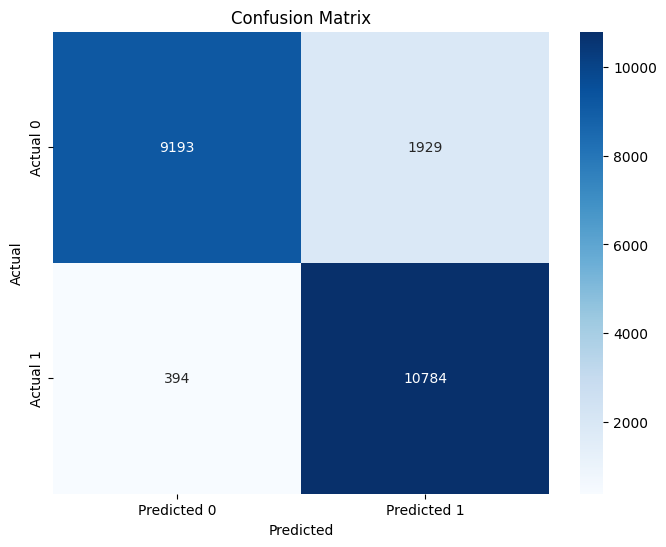

Precision: 0.8482655549437583
Recall: 0.9647521918053319
F1 Score: 0.902766732242267


In [ ]:
# Confusion Matrix
pred_df = predictions.select("successful_content", "prediction").toPandas()
cm = confusion_matrix(pred_df["successful_content"], pred_df["prediction"])
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# Visualisasi Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Precision, Recall, dan F1 Score
precision = precision_score(pred_df["successful_content"], pred_df["prediction"])
recall = recall_score(pred_df["successful_content"], pred_df["prediction"])
f1 = f1_score(pred_df["successful_content"], pred_df["prediction"])

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


## **Predictions using Linear Regression**

### **Inisialisasi Spark dan Dataframe**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when

# Inisialisasi Spark
spark = SparkSession.builder.appName("MLlib Linear Regression").getOrCreate()

# Konversi dataframe pandas ke Spark
spark_df = spark.createDataFrame(df)

# Membuat kolom 'successful_content' untuk klasifikasi sederhana
spark_df = spark_df.withColumn("successful_content", when(spark_df.episode_run_time > 50, 1).otherwise(0))


### **Preprocessing Data**

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler

# Encoding kolom kategori
indexer = StringIndexer(inputCols=["original_language", "type"], outputCols=["original_language_index", "type_index"])
indexed_df = indexer.fit(spark_df).transform(spark_df)

# Membuat vektor fitur
feature_columns = [
    "number_of_seasons","number_of_episodes", "vote_count",
    "vote_average", "popularity", "episode_run_time",
    "original_language_index", "type_index"
]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembled_df = assembler.transform(indexed_df)

# Normalisasi data
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaled_df = scaler.fit(assembled_df).transform(assembled_df)


### **Split Data dan Model Linear Regression**

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Membagi data
train_df, test_df = scaled_df.randomSplit([0.8, 0.2], seed=42)

# Membuat model regresi
lr = LinearRegression(featuresCol='scaled_features', labelCol='episode_run_time')
linearRegressionModel = lr.fit(train_df)

# Prediksi pada data uji
predictions = linearRegressionModel.transform(test_df)

# Evaluasi model
evaluator = RegressionEvaluator(labelCol="episode_run_time", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"RMSE: {rmse}")

evaluator_mae = RegressionEvaluator(labelCol="episode_run_time", predictionCol="prediction", metricName="mae")
mae = evaluator_mae.evaluate(predictions)
print(f"MAE: {mae}")

# Koefisien dan intercept
for name, coef in zip(feature_columns, linearRegressionModel.coefficients):
    print(f"Feature: {name}, Coefficient: {coef}")
print(f'Intercept: {linearRegressionModel.intercept}')

RMSE: 2.0742761106787356e-07
MAE: 1.5758069834126754e-07
Feature: number_of_seasons, Coefficient: 0.0
Feature: number_of_episodes, Coefficient: -1.2966868930511758e-07
Feature: vote_count, Coefficient: -7.250170298653622e-10
Feature: vote_average, Coefficient: -4.378743619803037e-08
Feature: popularity, Coefficient: -8.448838202776298e-10
Feature: episode_run_time, Coefficient: 24.59548786133264
Feature: original_language_index, Coefficient: 1.4019610870576798e-08
Feature: type_index, Coefficient: 1.3165382154292198e-07
Intercept: 1.9931331900820537e-07


### **Hyperparameter Tuning dengan Cross-Validation**

In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Menyusun grid parameter
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01, 0.001]) \
    .addGrid(lr.maxIter, [10, 50, 100, 200]) \
    .build()

# Cross Validator
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="episode_run_time", metricName="rmse"),
                          numFolds=5)

# Melatih model dengan cross-validation
model = crossval.fit(train_df)

# Model terbaik
best_model = model.bestModel

# Evaluasi ulang
predictions = best_model.transform(test_df)
rmse = RegressionEvaluator(labelCol="episode_run_time", metricName="rmse").evaluate(predictions)
mae = RegressionEvaluator(labelCol="episode_run_time", metricName="mae").evaluate(predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
for name, coef in zip(feature_columns, best_model.coefficients):
    print(f"Feature: {name}, Coefficient: {coef}")
print(f"Best Model Intercept: {best_model.intercept}")

RMSE: 0.0009917142272246712
MAE: 0.0007154585237817213
Feature: number_of_seasons, Coefficient: 0.0
Feature: number_of_episodes, Coefficient: -0.00012199551830895419
Feature: vote_count, Coefficient: -1.9412301635439648e-05
Feature: vote_average, Coefficient: 6.326873788088591e-05
Feature: popularity, Coefficient: 5.183235986537027e-06
Feature: episode_run_time, Coefficient: 24.59446158476256
Feature: original_language_index, Coefficient: 3.143862004101396e-05
Feature: type_index, Coefficient: 0.00011125211994599484
Best Model Intercept: 0.0017871037002726775


### **Visualisasi Prediksi**

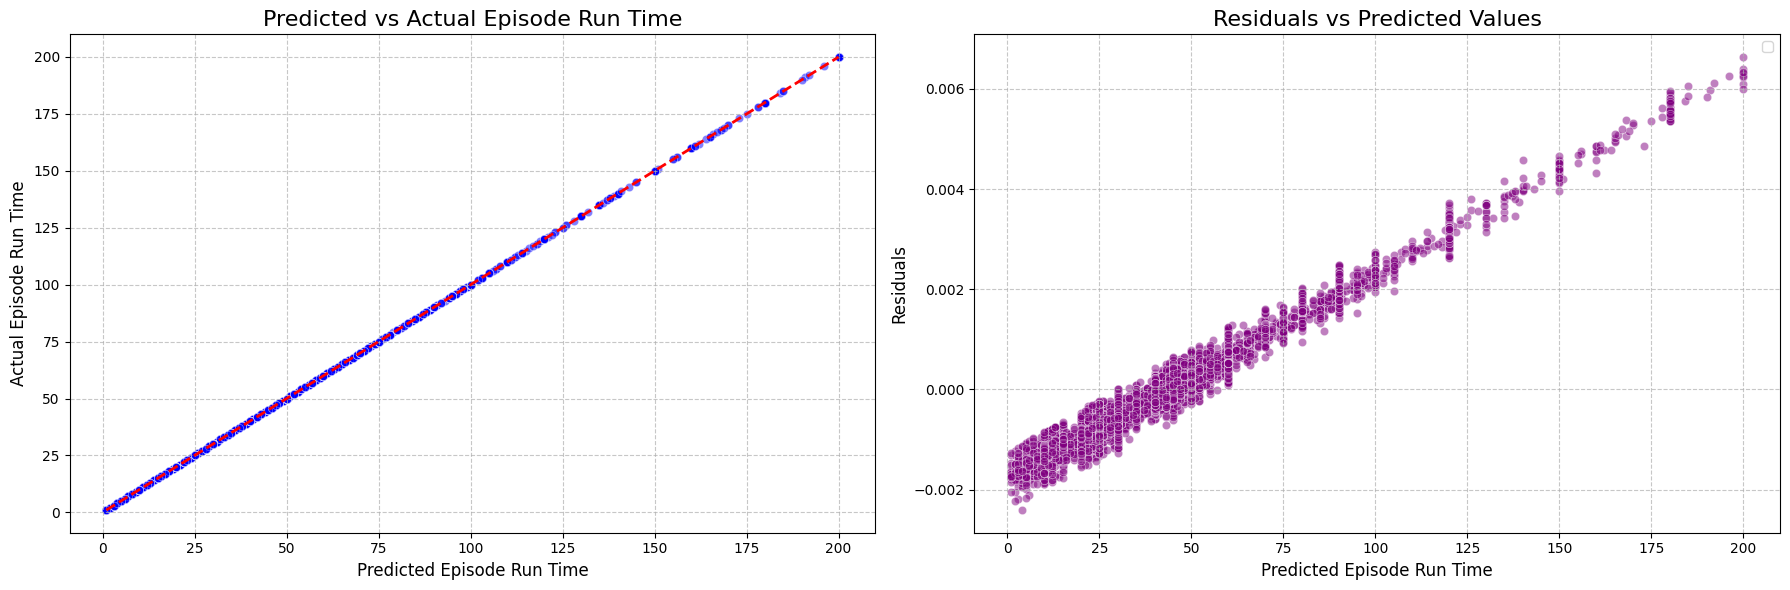

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.evaluation import RegressionEvaluator

# Mengambil prediksi dari model
predictions_pd = predictions.toPandas()

# Hitung residuals
predictions_pd['residuals'] = predictions_pd['episode_run_time'] - predictions_pd['prediction']

# Membuat figure dengan dua subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Visualisasi Predicted vs Actual
sns.scatterplot(x='prediction', y='episode_run_time', data=predictions_pd, alpha=0.5, color="blue", ax=ax1)
ax1.plot([min(predictions_pd['prediction']), max(predictions_pd['prediction'])],
         [min(predictions_pd['episode_run_time']), max(predictions_pd['episode_run_time'])],
         linestyle='--', color='red', linewidth=2)
ax1.set_title('Predicted vs Actual Episode Run Time', fontsize=16)
ax1.set_xlabel('Predicted Episode Run Time', fontsize=12)
ax1.set_ylabel('Actual Episode Run Time', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7)

# Visualisasi residuals
sns.scatterplot(x='prediction', y='residuals', data=predictions_pd, alpha=0.5, color="purple", ax=ax2)
# ax2.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Error Line')
ax2.set_title('Residuals vs Predicted Values', fontsize=16)
ax2.set_xlabel('Predicted Episode Run Time', fontsize=12)
ax2.set_ylabel('Residuals', fontsize=12)
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
